# **Capstone Project GRP4 NLP B**

## Installing Packages

In [2]:
!pip install -U textblob
!pip install translators
!pip install goslate
import goslate
!pip install translate
!pip install googletrans
import googletrans
from googletrans import Translator
!pip install langdetect
!pip install ftfy
!pip install rpy2

Requirement already up-to-date: textblob in /usr/local/lib/python3.6/dist-packages (0.15.3)
  Using cached https://files.pythonhosted.org/packages/a0/28/85c7aa31b80d150b772fbe4a229487bc6644da9ccb7e427dd8cc60cb8a62/pluggy-0.13.1-py2.py3-none-any.whl
ERROR: pytest 3.6.4 has requirement pluggy<0.8,>=0.5, but you'll have pluggy 0.13.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Using cached https://files.pythonhosted.org/packages/f5/f1/5a93c118663896d83f7bcbfb7f657ce1d0c0d617e6b4a443a53abcc658ca/pluggy-0.7.1-py2.py3-none-any.whl
ERROR: tox 3.20.1 has requirement pluggy>=0.12.0, but you'll have pluggy 0.7.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: pluggy 0.13.1
    

## Importing libraries

In [3]:
from google.colab import drive
import gc 

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Input, Flatten, GlobalMaxPool1D, SpatialDropout1D

from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors # Gensim contains word2vec models and processing tools
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import binarize

from nltk import word_tokenize
from nltk.corpus import wordnet 

import os
import nltk
import string
import re

from collections import Counter
from nltk.corpus import stopwords
from translate import Translator
from langdetect import detect
from langdetect import detect_langs
from langdetect import DetectorFactory
DetectorFactory.seed = 0

import random
random.seed(0)
import warnings
warnings.filterwarnings("ignore")
%load_ext rpy2.ipython
import random as rnd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

from textblob import Word
from ftfy import fix_text
tf.__version__
#from googletrans import Translator
#translator = Translator(service_urls=['translate.googleapis.com'])

'2.3.0'

## Downloading NLTK data

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Mount your Google Drive

In [6]:
#### mounting google drive ####
drive.mount("/content/drive/")
folder_path = ("/content/drive/MyDrive/Capstone Project - Ticket Routing NLP") 

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Loading data and creating a pickle function

In [7]:
ticket_data = ""
import pickle
pickle_flag = False

## Get Pickle Data
def get_pickle_data(filename):
  pickle_data = open(folder_path + "/" + filename,'rb')
  return pickle.load(pickle_data)

## Dump Pickle Data
def pickle_dump(data_to_dump, filename):
  filehandler = open((folder_path+ "/" + filename),"wb")
  pickle.dump(data_to_dump,filehandler)

if not os.path.exists(folder_path + "/input_data.pickle"):
  ticket_data = pd.read_excel(folder_path + "/input_data.xlsx")
  print("picking from excel")
else:
  ticket_data = get_pickle_data("input_data.pickle")
  print("picking from pickle")
  print(len(ticket_data))

pickle_dump(ticket_data, "input_data.pickle")

picking from pickle
8500


## Data Analysis Begins

In [8]:
ticket_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8500 entries, 0 to 8499
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Short description  8492 non-null   object
 1   Description        8499 non-null   object
 2   Caller             8500 non-null   object
 3   Assignment group   8500 non-null   object
dtypes: object(4)
memory usage: 265.8+ KB


In [9]:
ticket_data.head()

,Short description,Description,Caller,Assignment group
0,login issue,-verified user details.(employee# & manager na...,spxjnwir pjlcoqds,GRP_0
1,outlook,\r\n\r\nreceived from: hmjdrvpb.komuaywn@gmail...,hmjdrvpb komuaywn,GRP_0
2,cant log in to vpn,\r\n\r\nreceived from: eylqgodm.ybqkwiam@gmail...,eylqgodm ybqkwiam,GRP_0
3,unable to access hr_tool page,unable to access hr_tool page,xbkucsvz gcpydteq,GRP_0
4,skype error,skype error,owlgqjme qhcozdfx,GRP_0


In [10]:
unique_callers = ticket_data['Caller'].unique()
unique_callers.shape

(2950,)

In [11]:
Func_group = ticket_data['Assignment group'].unique()
Func_group.shape

(74,)

In [12]:
TargetGroupCnt=ticket_data['Assignment group'].value_counts()
TargetGroupCnt.describe()

count      74.000000
mean      114.864865
std       465.747516
min         1.000000
25%         5.250000
50%        26.000000
75%        84.000000
max      3976.000000
Name: Assignment group, dtype: float64

In [13]:
ticket_data.Caller.value_counts()

bpctwhsn kzqsbmtp    810
ZkBogxib QsEJzdZO    151
fumkcsji sarmtlhy    134
rbozivdq gmlhrtvp     87
rkupnshb gsmzfojw     71
                    ... 
usdhpatm icgmphjk      1
rbkvofgu jthclzow      1
svmkobqj sgqtdubv      1
ebxrlknc txnvwupy      1
vcnjqfta islabdft      1
Name: Caller, Length: 2950, dtype: int64

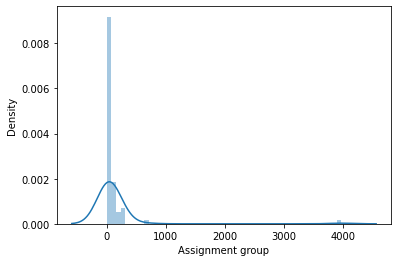

In [14]:
sns.distplot(ticket_data['Assignment group'].value_counts())

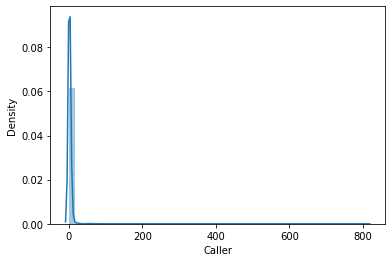

In [15]:
sns.distplot(ticket_data['Caller'].value_counts())

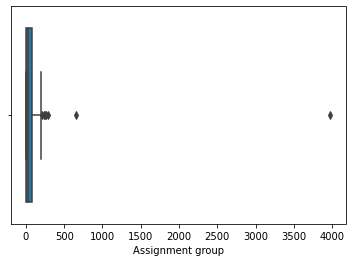

In [16]:
sns.boxplot(ticket_data['Assignment group'].value_counts())

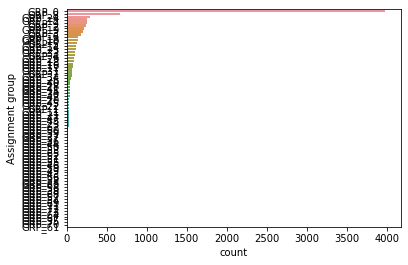

In [17]:
sns.countplot(y="Assignment group", data=ticket_data, order=ticket_data['Assignment group'].value_counts().index )

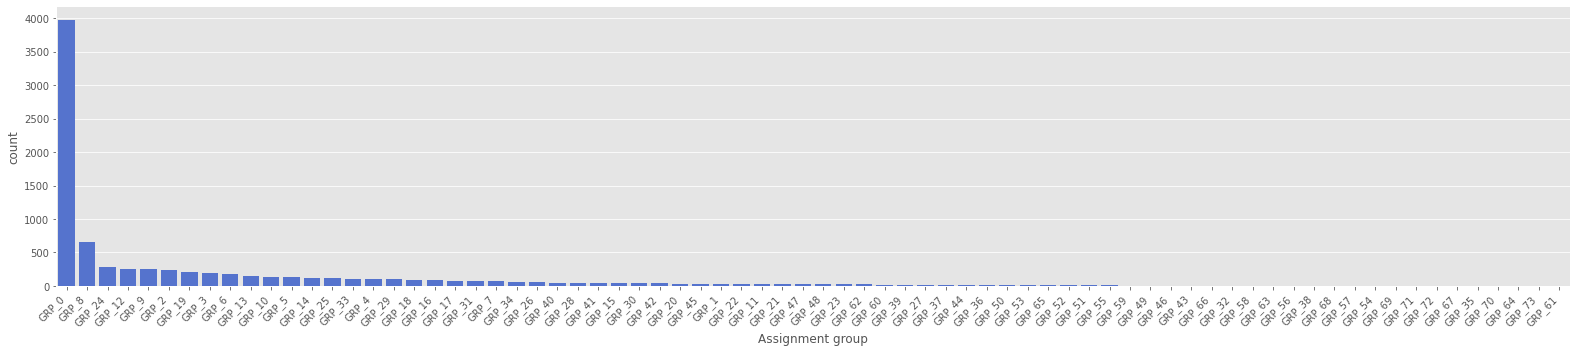

In [18]:
plt.style.use('ggplot')
%matplotlib inline

descending_order = ticket_data['Assignment group'].value_counts().sort_values(ascending=False).index
plt.subplots(figsize=(22,5))
#added code for x label rotate 
ax=sns.countplot(x='Assignment group', data=ticket_data, color='royalblue',order=descending_order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [19]:
ticket_data.isnull().values.any()

True

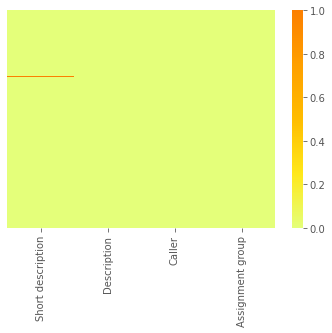

In [20]:
sns.heatmap(ticket_data.isnull(), yticklabels=False, cmap="Wistia")

In [21]:
ticket_data['Description'].fillna(value=' ', inplace=True)
ticket_data['Short description'].fillna(value=' ', inplace=True)
ticket_data.isnull().values.any()

False

## TODO: Somewhere in the initial EDA, We must remove the records where both Short desc and Desc are blank. While there is no such record in the data, we should still have this

In [22]:
summary_data=ticket_data.pivot_table(columns = "Assignment group",aggfunc='count')
summary_data

Assignment group,GRP_0,GRP_1,GRP_10,GRP_11,GRP_12,GRP_13,GRP_14,GRP_15,GRP_16,GRP_17,GRP_18,GRP_19,GRP_2,GRP_20,GRP_21,GRP_22,GRP_23,GRP_24,GRP_25,GRP_26,GRP_27,GRP_28,GRP_29,GRP_3,GRP_30,GRP_31,GRP_32,GRP_33,GRP_34,GRP_35,GRP_36,GRP_37,GRP_38,GRP_39,GRP_4,GRP_40,GRP_41,GRP_42,GRP_43,GRP_44,GRP_45,GRP_46,GRP_47,GRP_48,GRP_49,GRP_5,GRP_50,GRP_51,GRP_52,GRP_53,GRP_54,GRP_55,GRP_56,GRP_57,GRP_58,GRP_59,GRP_6,GRP_60,GRP_61,GRP_62,GRP_63,GRP_64,GRP_65,GRP_66,GRP_67,GRP_68,GRP_69,GRP_7,GRP_70,GRP_71,GRP_72,GRP_73,GRP_8,GRP_9
Caller,3976,31,140,30,257,145,118,39,85,81,88,215,241,36,29,31,25,289,116,56,18,44,97,200,39,69,4,107,62,1,15,16,3,19,100,45,40,37,5,15,35,6,27,25,6,129,14,8,9,11,2,8,3,2,3,6,184,20,1,25,3,1,11,4,1,3,2,68,1,2,2,1,661,252
Description,3976,31,140,30,257,145,118,39,85,81,88,215,241,36,29,31,25,289,116,56,18,44,97,200,39,69,4,107,62,1,15,16,3,19,100,45,40,37,5,15,35,6,27,25,6,129,14,8,9,11,2,8,3,2,3,6,184,20,1,25,3,1,11,4,1,3,2,68,1,2,2,1,661,252
Short description,3976,31,140,30,257,145,118,39,85,81,88,215,241,36,29,31,25,289,116,56,18,44,97,200,39,69,4,107,62,1,15,16,3,19,100,45,40,37,5,15,35,6,27,25,6,129,14,8,9,11,2,8,3,2,3,6,184,20,1,25,3,1,11,4,1,3,2,68,1,2,2,1,661,252


In [23]:
ticket_data['Assignment group'].unique()

array(['GRP_0', 'GRP_1', 'GRP_3', 'GRP_4', 'GRP_5', 'GRP_6', 'GRP_7',
       'GRP_8', 'GRP_9', 'GRP_10', 'GRP_11', 'GRP_12', 'GRP_13', 'GRP_14',
       'GRP_15', 'GRP_16', 'GRP_17', 'GRP_18', 'GRP_19', 'GRP_2',
       'GRP_20', 'GRP_21', 'GRP_22', 'GRP_23', 'GRP_24', 'GRP_25',
       'GRP_26', 'GRP_27', 'GRP_28', 'GRP_29', 'GRP_30', 'GRP_31',
       'GRP_33', 'GRP_34', 'GRP_35', 'GRP_36', 'GRP_37', 'GRP_38',
       'GRP_39', 'GRP_40', 'GRP_41', 'GRP_42', 'GRP_43', 'GRP_44',
       'GRP_45', 'GRP_46', 'GRP_47', 'GRP_48', 'GRP_49', 'GRP_50',
       'GRP_51', 'GRP_52', 'GRP_53', 'GRP_54', 'GRP_55', 'GRP_56',
       'GRP_57', 'GRP_58', 'GRP_59', 'GRP_60', 'GRP_61', 'GRP_32',
       'GRP_62', 'GRP_63', 'GRP_64', 'GRP_65', 'GRP_66', 'GRP_67',
       'GRP_68', 'GRP_69', 'GRP_70', 'GRP_71', 'GRP_72', 'GRP_73'],
      dtype=object)

In [24]:
len(ticket_data['Assignment group'].unique())

74

In [25]:
df_assg = ticket_data['Assignment group'].value_counts().reset_index()
df_assg['percentage'] = (df_assg['Assignment group']/df_assg['Assignment group'].sum())*100
df_assg.head()

,index,Assignment group,percentage
0,GRP_0,3976,46.776471
1,GRP_8,661,7.776471
2,GRP_24,289,3.400000
3,GRP_12,257,3.023529
4,GRP_9,252,2.964706


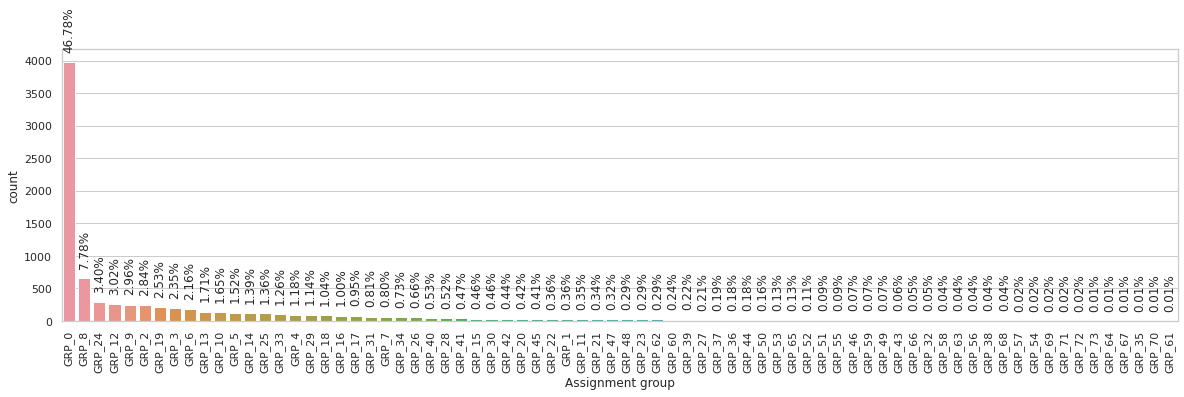

In [26]:
sns.set(style="whitegrid")
plt.figure(figsize=(20,5))
ax = sns.countplot(x="Assignment group", data=ticket_data, order=ticket_data["Assignment group"].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
for p in ax.patches:
    ax.annotate(str(format(p.get_height()/len(ticket_data.index)*100, '.2f')+"%"), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'bottom', rotation=90, xytext = (0, 10), textcoords = 'offset points')

#### Top 20 Assignment groups with highest number of tickets

In [27]:
df_top_assg = ticket_data['Assignment group'].value_counts().nlargest(20).reset_index()
df_top_assg

,index,Assignment group
0,GRP_0,3976
1,GRP_8,661
2,GRP_24,289
3,GRP_12,257
4,GRP_9,252
5,GRP_2,241
6,GRP_19,215
7,GRP_3,200
8,GRP_6,184
9,GRP_13,145


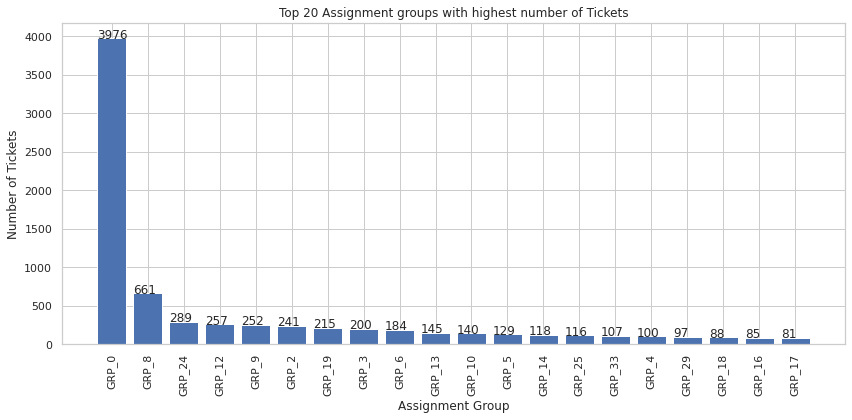

In [28]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_top_assg['index'],df_top_assg['Assignment group'])
plt.title('Top 20 Assignment groups with highest number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

#### Visualize the percentage of incidents per assignment group

In [29]:
df_bottom_assg = ticket_data['Assignment group'].value_counts().nsmallest(20).reset_index()
df_bottom_assg

,index,Assignment group
0,GRP_73,1
1,GRP_64,1
2,GRP_67,1
3,GRP_35,1
4,GRP_70,1
5,GRP_61,1
6,GRP_57,2
7,GRP_54,2
8,GRP_69,2
9,GRP_71,2


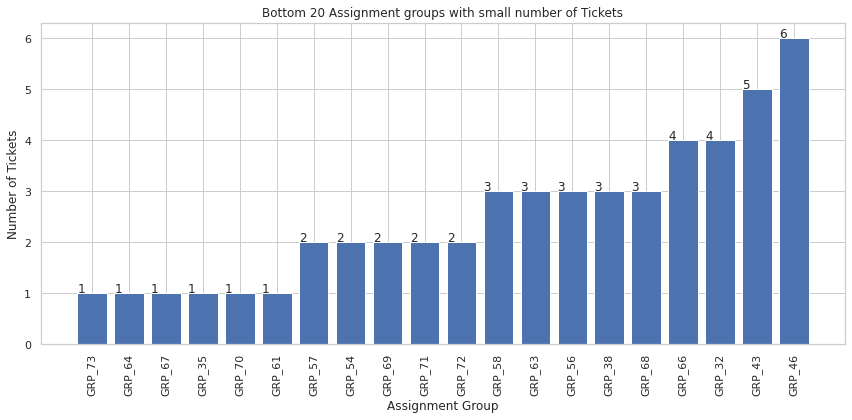

In [30]:
plt.figure(figsize=(12,6))
bars = plt.bar(df_bottom_assg['index'],df_bottom_assg['Assignment group'])
plt.title('Bottom 20 Assignment groups with small number of Tickets')
plt.xlabel('Assignment Group')
plt.xticks(rotation=90)
plt.ylabel('Number of Tickets')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x(), yval + .005, yval)
plt.tight_layout()
plt.show()

In [31]:
df_tickets = pd.DataFrame(columns=['Description','Ticket Count'])
one_ticket = {'Description':'1','Ticket Count':len(df_assg[df_assg['Assignment group'] < 2])}
_2_5_ticket = {'Description':'2-5',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 1)& (df_assg['Assignment group'] < 6) ])}
_10_ticket = {'Description':' 6-10',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 5)& (df_assg['Assignment group'] < 11)])}
_10_20_ticket = {'Description':' 11-20',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 10)& (df_assg['Assignment group'] < 21)])}
_20_50_ticket = {'Description':' 21-50',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 20)& (df_assg['Assignment group'] < 51)])}
_51_100_ticket = {'Description':' 51-100',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 50)& (df_assg['Assignment group'] < 101)])}
_100_ticket = {'Description':' >100',
              'Ticket Count':len(df_assg[(df_assg['Assignment group'] > 100)])}
#append row to the dataframe
df_tickets = df_tickets.append([one_ticket,_2_5_ticket,_10_ticket,
                          _10_20_ticket,_20_50_ticket,_51_100_ticket,_100_ticket], ignore_index=True)

df_tickets

,Description,Ticket Count
0,1,6
1,2-5,13
2,6-10,6
3,11-20,9
4,21-50,16
5,51-100,9
6,>100,15


(-1.1019890551483629,
 1.1224353061977401,
 -1.1079626168723997,
 1.1159579389457492)

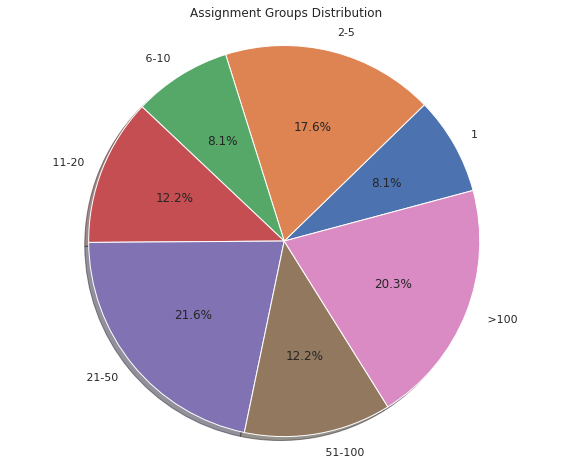

In [32]:
plt.figure(figsize=(10, 8))
plt.pie(df_tickets['Ticket Count'],labels=df_tickets['Description'],autopct='%1.1f%%', startangle=15, shadow = True);
plt.title('Assignment Groups Distribution')
plt.axis('equal')

In [33]:
ticket_data[ticket_data['Short description'].isnull()]

,Short description,Description,Caller,Assignment group


In [34]:
ticket_data[ticket_data['Description'].isnull()]

,Short description,Description,Caller,Assignment group


## Begin Data Cleaning

### Replacing NaN

In [35]:
#Replace NaN values in Short Description and Description columns
ticket_data['Short description'] = ticket_data['Short description'].replace(np.nan, '', regex=True)
ticket_data['Description'] = ticket_data['Description'].replace(np.nan, '', regex=True)

### Decoding the data

In [36]:
#Lets encode the string, to make it easier to be passed to language detection api.
def fn_decode_to_ascii(df):
  text = df.encode().decode('utf-8').encode('ascii', 'ignore')
  return text.decode("utf-8") 

### Prepping potential boilerplate text for removal

In [37]:
#As different lines are of different length. We need to pad the our sequences using the max length
contractions = { 
"ain't": "am not / are not / is not / has not / have not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is / how does",
"I'd": "I had / I would",
"I'd've": "I would have",
"I'll": "I shall / I will",
"I'll've": "I shall have / I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

### Defining Translation functions

In [38]:
##************************************************************************************************************
### Getting data from Translation object
def get_text_from_translation(translation):
  print (translation.text)
  translated_text = translation.text.split("text")[1]
  translated_text = translated_text.split("Pronunciation")[0]
  translated_text = translated_text.split("=")[1]
  translated_text = translated_text.strip()
  translated_text = translated_text.replace(translated_text[len(translated_text)-1],"")
  return translated_text

##Translating word by word using Google and MyMemory
##TODO: Change the detect function to translator.detect
def translate_word_by_word(sentence):
  words = sentence.split(" ")
  new_words = []
  for word in words:
    lang = detect(word)
    translator = Translator(provider='mymemory', to_lang="en", from_lang = lang, secret_access_key=None)
    new_word = translator.translate(word)
    new_words.append(new_word)
  return " ".join(new_words)

##Translating entire sentences using mymemory (pypi)
def translate_sentence(sentence):
  lang = detect(sentence)
  translator = Translator(provider='mymemory', to_lang="en", from_lang = lang, secret_access_key=None)
  return translator.translate(sentence)

##Translating entire column using the above functions
def translate_column(columnvalue):  
  try:                                                          
    sentence_translated = translate_sentence(columnvalue)
    return sentence_translated
  except:                                                       
    return columnvalue    

#### NOTE: THESE FUNCTIONS ABOVE ARE NOT IN USE. WE ARE LEVERAGING THE ONES BELOW
##************************************************************************************************************

## Detecting language using google
def detect_lang(desc):
  try:
    if desc != "":
      return translator.detect(desc)
    else:
      return "en"
  except:
    return "en"
    
# Function to translate the text to english.
def fn_translate(sentence):
  try:
    if translator.detect(sentence) == "en":
        return sentence
    else:
        return translator.translate(df, src = lang, dest = "en").text
  except:
    return sentence

In [39]:
#ticket_data['Description'] = ticket_data['Description'].apply(translate_column)
#ticket_data['Short description'] = ticket_data['Short description'].apply(translate_column)

### Function for cleaning data

In [40]:
max_features = 10000
MAX_LENGTH = 300
embedding_size = 200

def clean_text(text):
    if text != "":          
      '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
      and remove words containing numbers.'''
      text=text.replace(('first name: ').lower(),'firstname')
      text=text.replace(('last name: ').lower(),'lastname')
      text=text.replace(('received from:').lower(),'')
      text=text.replace('email:','')
      text=text.replace('email address:','') 
      index1=text.find('from:')
      index2=text.find('\nsddubject:')
      text=text.replace(text[index1:index2],'')
      index3=text.find('[cid:image')
      index4=text.find(']')
      text=text.replace(text[index3:index4],'')
      text=text.replace('subject:','')
      text=text.replace('received from:','')
      text=text.replace('this message was sent from an unmonitored email address', '')
      text=text.replace('please do not reply to this message', '')
      text=text.replace('monitoring_tool@company.com','MonitoringTool')
      text=text.replace('select the following link to view the disclaimer in an alternate language','')
      text=text.replace('description problem', '') 
      text=text.replace('steps taken far', '')
      text=text.replace('customer job title', '')
      text=text.replace('sales engineer contact', '')
      text=text.replace('description of problem:', '')
      text=text.replace('steps taken so far', '')
      text=text.replace('please do the needful', '')
      text=text.replace('please note that ', '')
      text=text.replace('please find below', '')
      text=text.replace('date and time', '')
      text=text.replace('kindly refer mail', '')
      text=text.replace('name:', '')
      text=text.replace('language:', '')
      text=text.replace('customer number:', '')
      text=text.replace('telephone:', '')
      text=text.replace('summary:', '')
      text=text.replace('sincerely', '')
      text=text.replace('company inc', '')
      text=text.replace('importance:', '')
      text=text.replace('gmail.com', '')
      text=text.replace('company.com', '')
      text=text.replace('microsoftonline.com', '')
      text=text.replace('company.onmicrosoft.com', '')
      text=text.replace('hello', '')
      text=text.replace('hallo', '')
      text=text.replace('hi it team', '')
      text=text.replace('hi team', '')
      text=text.replace('hi', '')
      text=text.replace('best', '')
      text=text.replace('kind', '')
      text=text.replace('regards', '')
      text=text.replace('good morning', '')
      text=text.replace('please', '')
      text=text.replace('regards', '')
      text = re.sub(r'\<a href', ' ', text)
      text = re.sub(r'&amp;', '', text)
      text = re.sub(r'<br />', ' ', text)    
      text = re.sub(r'\S+@\S+', '', text)
      text = re.sub(r'\d+','' ,text)
      text = re.sub(r'#','', text)
      text = re.sub(r'&;?', 'and',text)
      text = re.sub(r'\&\w*;', '', text)
      text = re.sub(r'https?:\/\/.*\/\w*', '', text)
      custom_punctuation='!"#$%&\'()*+,-./:;<=>?@[\\]^`{|}~'
      text = re.sub(r'\w*\d\w*', '', text)
      text = re.sub(r'\[.*?\]', '', text)
      text = re.sub(r'https?://\S+|www\.\S+', '', text)
      text = re.sub(r'<.*?>+', '', text)
      text= ''.join(c for c in text if c <= '\uFFFF') 
      text = text.strip()      
      text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
      text = ' '.join(re.sub("[^\u0030-\u0039\u0041-\u005a\u0061-\u007a]", " ", text).split())
      text = re.sub(r'\r\n', '', text)
      text = re.sub(r'\n', '', text)
      text = re.sub(r'\S+@\S+', '', text)

      text = text.lower()
    return text

### Data cleaning, stop word removal and lemmatization

In [41]:
ticket_data['Description'] = ticket_data['Description'].apply(fn_decode_to_ascii)
ticket_data['Short description'] = ticket_data['Short description'].apply(fn_decode_to_ascii)
ftfy_ShortDescription = []
for Short_Description in ticket_data['Short description']:
  ftfy_ShortDescription.append(fix_text(Short_Description))
ticket_data['Short description']= ftfy_ShortDescription
ftfy_Description = []
for Description in ticket_data['Description']:
  ftfy_Description.append(fix_text(Description))
ticket_data['Description']= ftfy_Description
ticket_data['lang_desc'] = ticket_data['Description'].apply(detect_lang)
ticket_data['lang_short_desc'] = ticket_data['Short description'].apply(detect_lang)
ticket_data['Description'] = ticket_data.apply(lambda x: fn_translate(x['Description']), axis=1)
ticket_data['Short description'] = ticket_data.apply(lambda x: fn_translate(x['Short description']), axis=1)
ticket_data["Description"] = ticket_data["Description"].apply(clean_text)
ticket_data["Short description"] = ticket_data["Short description"].apply(clean_text)
print(len(ticket_data))

8500


In [42]:
ticket_pivot = ticket_data.pivot_table(aggfunc="count",columns ="Assignment group", values="Caller")
ticket_nums = np.array(ticket_pivot)
ticket_cols = ticket_pivot.columns
ticket_pivot_df = pd.DataFrame(data = ticket_nums, columns = ticket_cols, index = ["Number of tickets"])
ticket_pivot_df = ticket_pivot_df.transpose()
ticket_pivot_df.reset_index(inplace=True)

In [43]:
def filter_group_augment (groupname):
  if groupname in list(ticket_pivot_df[(ticket_pivot_df["Number of tickets"]>20) & (ticket_pivot_df["Number of tickets"]<1000)]["Assignment group"]):
    return True
  else:
    return False

def filter_group_large (groupname):
  if groupname in list(ticket_pivot_df[(ticket_pivot_df["Number of tickets"]>=1000)]["Assignment group"]):
    return True
  else:
    return False

def filter_group_small (groupname):
  if groupname in list(ticket_pivot_df[(ticket_pivot_df["Number of tickets"]<=20)]["Assignment group"]):
    return True
  else:
    return False

def filter_group_AI (groupname):
  if groupname in list(ticket_pivot_df[(ticket_pivot_df["Number of tickets"]>20)]["Assignment group"]):
    return True
  else:
    return False

In [44]:
data_to_be_augmented = ticket_data[ticket_data["Assignment group"].apply(filter_group_augment)]
data_large_tickets = ticket_data[ticket_data["Assignment group"].apply(filter_group_large)]
data_small_tickets = ticket_data[ticket_data["Assignment group"].apply(filter_group_small)]

In [45]:
def replace_with_synonym(sentence):
  if sentence != "":
    synonym = ""
    words = sentence.split(" ")    
    repl_num = 0
    syn_idx = 0
    for i in range(5):
      if len(words) > 1:
        repl_num = rnd.randint(0,len(words)-1)
      elif len(words) == 1:
        repl_num = 0
      else:
        return sentence
      syns = wordnet.synsets(words[repl_num])
      if len(syns) > 1:
        syn_idx = rnd.randint(0,len(syns)-1)
        synonym = syns[syn_idx].lemmas()[0].name()
      elif len(syns) == 1:
        syn_idx = 0
        synonym = syns[syn_idx].lemmas()[0].name()
      else:
        synonym = ""
      if synonym != "":
        sentence = sentence.replace(words[repl_num], synonym)
  return sentence

def drop_words(sentence):
  if sentence != "":
    words = sentence.split(" ")    
    repl_num = 0
    for i in range(5):
      if len(words) > 1:
        repl_num = rnd.randint(0,len(words)-1)
      elif len(words) == 1:
        repl_num = 0
      else:
        return sentence
      words[repl_num] = ""
    sentence = " ".join(words)
  return sentence

def scatter_sentences(para):
  sentences = para.split(".")
  i=0
  for sentence in sentences:
      sentences[i] = sentence.strip()
      i = i+1
  total = len(sentences)
  i = 0
  new_order = []
  while (len(new_order) < total):
      num = rnd.randint(0,total-1)
      if num not in new_order:
          new_order.append(num)
          i = i + 1
  new_sentences = [sentences[i] for i in new_order]
  total_sentences = len(new_sentences)
  return_para = ""
  for i in range(total_sentences):
    if not new_sentences[i] == "":
      if return_para == "":
        return_para = new_sentences[i]
      else:
        return_para = return_para + "." + new_sentences[i]
  return return_para

In [46]:
ticket_pivot_df = ticket_pivot_df[(ticket_pivot_df["Number of tickets"]>20) & (ticket_pivot_df["Number of tickets"]<1000)]

In [47]:
ticket_pivot_df = ticket_pivot_df.reset_index()
ticket_pivot_df.drop(["index"], axis = 1, inplace = True)

In [48]:
def augment_data(df):
  total_grps = len(ticket_pivot_df)
  ticket_data_updated = df.copy()
  list_to_add = []
  list_df = []
  col_names = ticket_data_updated.columns.values.tolist()
  for i in range(total_grps):
    grpname = ticket_pivot_df["Assignment group"][i]
    group_df = ticket_data_updated[ticket_data_updated["Assignment group"]==grpname]
    list_df = group_df.values.tolist()
    group_df = None
    records_added = ticket_pivot_df["Number of tickets"][i]
    while records_added < 330:
      list_df = list_df + list_df
      records_added = records_added + records_added
    list_to_add = list_to_add + list_df
    list_df = []
    gc.collect()
  #ticket_data_updated.info()
  #ticket_data_updated = pd.DataFrame(data = final_df, columns= col_names)
  df_to_add = pd.DataFrame(data = list_to_add, columns = ticket_data.columns)
  df_to_add["Description"] = df_to_add["Description"].apply(replace_with_synonym)
  df_to_add["Short description"] = df_to_add["Short description"].apply(replace_with_synonym)
  ticket_data_updated = pd.concat([ticket_data_updated, df_to_add],axis = 0)
  print("first", gc.collect())

  df_to_add = pd.DataFrame(data = list_to_add, columns = ticket_data.columns)
  df_to_add["Description"] = df_to_add["Description"].apply(scatter_sentences)
  df_to_add["Short description"] = df_to_add["Short description"].apply(scatter_sentences)
  ticket_data_updated = pd.concat([ticket_data_updated, df_to_add],axis = 0) 
  print("second:", gc.collect())

  df_to_add = pd.DataFrame(data = list_to_add, columns = ticket_data.columns)
  df_to_add["Description"] = df_to_add["Description"].apply(drop_words)
  df_to_add["Short description"] = df_to_add["Short description"].apply(drop_words)
  ticket_data_updated = pd.concat([ticket_data_updated, df_to_add],axis = 0)
  print("third", gc.collect())
  return ticket_data_updated

def check_small_group(grp):
  if grp in list(ticket_pivot_df[ticket_pivot_df["Number of tickets"] <= 20]["Assignment group"]):
    return True
  return False

### Augment the data here
augmented_data = ""
if os.path.exists(folder_path + "/" + "augmented_data.pickle"):
  augmented_data = get_pickle_data("augmented_data.pickle")
  print("picking from pickle")
else:
  augmented_data = augment_data(data_to_be_augmented)
  print("augmented")

augmented_data = pd.concat([augmented_data,data_large_tickets], axis = 0)
augmented_data = pd.concat([augmented_data,data_small_tickets], axis = 0)

augmented_data = augmented_data.reset_index()
augmented_data.drop(["index"], axis = 1, inplace = True)

pickle_dump(augmented_data, "augmented_data.pickle")
augmented_data.head()

picking from pickle


,Short description,Description,Caller,Assignment group,lang_desc,lang_short_desc
0,event criticalhostname the value of mountpoint...,event criticalhostname the value of mountpoint...,jyoqwxhz clhxsoqy,GRP_1,en,en
1,when undocking pc screen will not come back,when undocking pc screen will not come back,sigfdwcj reofwzlm,GRP_3,en,en
2,duplication of network address,kxsceyzonaokumlb gentles i have two devices th...,kxsceyzo naokumlb,GRP_4,en,en
3,reroute jobs on printer to printer issue needs...,yisohglruvteflgb the printer printer is not wo...,yisohglr uvteflgb,GRP_5,en,en
4,job job failed in jobscheduler at,monitoringtool job job failed in jobscheduler at,bpctwhsn kzqsbmtp,GRP_6,en,en


In [49]:
ticket_pivot = augmented_data.pivot_table(aggfunc="count",columns ="Assignment group", values="Caller")
ticket_nums = np.array(ticket_pivot)
ticket_cols = ticket_pivot.columns
ticket_pivot_df = pd.DataFrame(data = ticket_nums, columns = ticket_cols, index = ["Number of tickets"])
ticket_pivot_df = ticket_pivot_df.transpose()
ticket_pivot_df.reset_index(inplace=True)

In [50]:
deep_learning_df = " "
if os.path.exists(folder_path + "/deep_learning_df.pickle"):
  deep_learning_df = get_pickle_data("deep_learning_df.pickle")
else:
  deep_learning_df = augmented_data[augmented_data["Assignment group"].apply(filter_group_AI)]
deep_learning_df = deep_learning_df.reset_index()
deep_learning_df.drop(["index"], axis = 1, inplace = True)
deep_learning_df["Description_New"] = deep_learning_df["Short description"] + deep_learning_df["Description"]
pickle_dump(deep_learning_df, "deep_learning_df.pickle")

In [51]:
deep_learning_df.shape

(65337, 7)

In [52]:
augmented_data.shape

(69765, 6)

In [53]:
stop = stopwords.words('english')
augmented_data["Description"] = augmented_data["Description"].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
augmented_data["Short description"] = augmented_data["Short description"].apply(lambda x: " ".join(x for x in str(x).split() if x not in stop))
augmented_data['Short description']= augmented_data['Short description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))
augmented_data['Description']= augmented_data['Description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in str(x).split()]))

pickle_dump(augmented_data, "lemmatized_data.pickle")
augmented_data.head()

,Short description,Description,Caller,Assignment group,lang_desc,lang_short_desc
0,event criticalhostname value mountpoint thresh...,event criticalhostname value mountpoint thresh...,jyoqwxhz clhxsoqy,GRP_1,en,en
1,undocking pc screen come back,undocking pc screen come back,sigfdwcj reofwzlm,GRP_3,en,en
2,duplication network address,kxsceyzonaokumlb gentles two device trying sha...,kxsceyzo naokumlb,GRP_4,en,en
3,reroute job printer printer issue need resolve...,yisohglruvteflgb printer printer working need ...,yisohglr uvteflgb,GRP_5,en,en
4,job job failed jobscheduler,monitoringtool job job failed jobscheduler,bpctwhsn kzqsbmtp,GRP_6,en,en


In [54]:
ticket_data["lang_desc"].value_counts()

en    8500
Name: lang_desc, dtype: int64

In [55]:
ticket_data["lang_short_desc"].value_counts()

en    8500
Name: lang_short_desc, dtype: int64

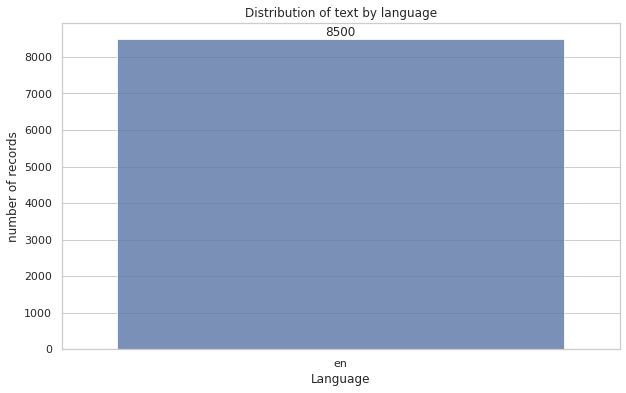

In [56]:
x = ticket_data["lang_desc"].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribution of text by language")
plt.ylabel('number of records')
plt.xlabel('Language')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

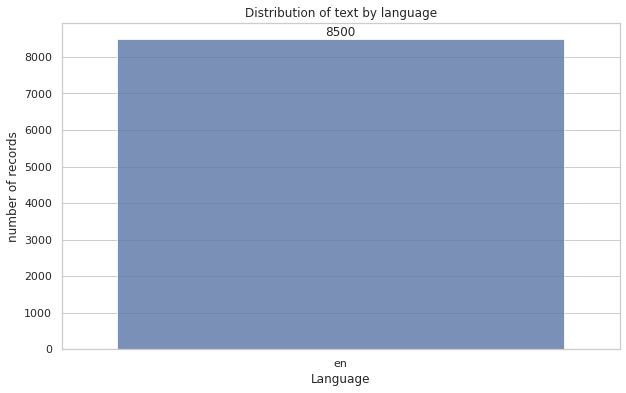

In [57]:
x = ticket_data["lang_short_desc"].value_counts()
x=x.sort_index()
plt.figure(figsize=(10,6))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Distribution of text by language")
plt.ylabel('number of records')
plt.xlabel('Language')
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show();

## Feature Engineering

In [58]:
augmented_data['Description_New'] = augmented_data['Short description'] + augmented_data['Description']
augmented_data['num_wds'] = augmented_data['Description_New'].apply(lambda x: len(x.split()))
augmented_data['num_wds'].mean()

20.43117609116319

In [59]:
print(augmented_data['num_wds'].max())
print(augmented_data['num_wds'].min())

957
0


In [60]:
len(augmented_data[augmented_data['num_wds']==0])

2516

In [61]:
augmented_data['uniq_wds'] = augmented_data['Description_New'].str.split().apply(lambda x: len(set(x)))
augmented_data['uniq_wds'].head()

0     7
1     6
2    31
3    38
4     4
Name: uniq_wds, dtype: int64

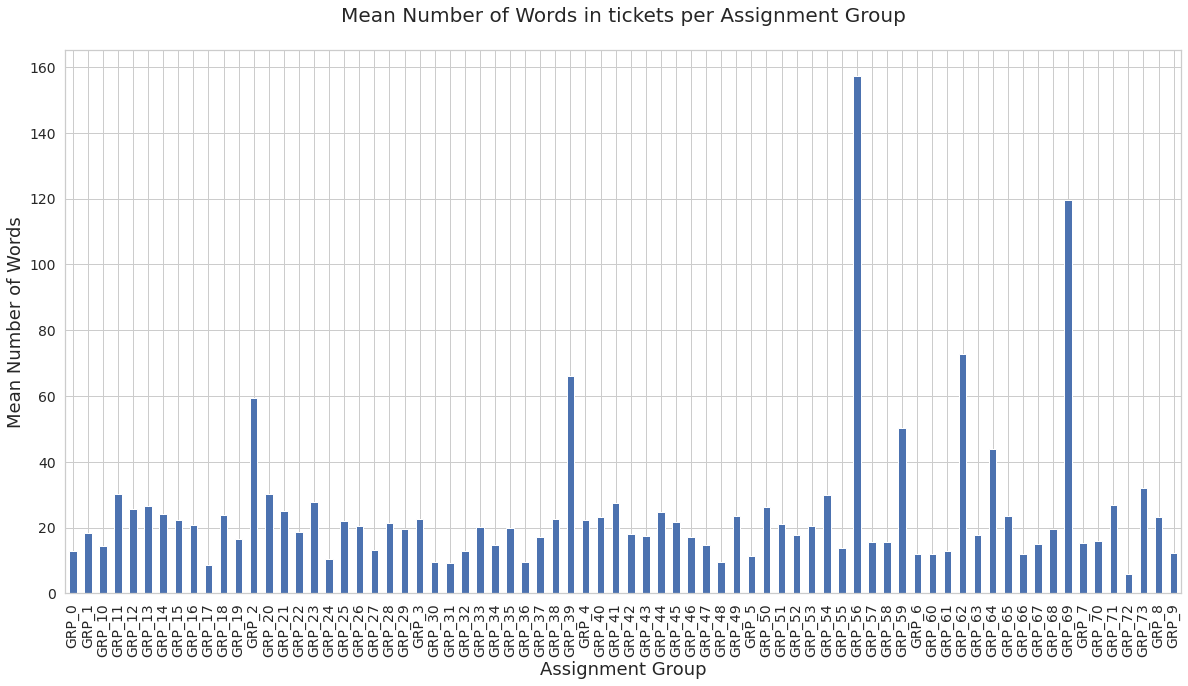

In [62]:
assign_grps = augmented_data.groupby('Assignment group')
ax=assign_grps['num_wds'].aggregate(np.mean).plot(kind='bar', fontsize=14, figsize=(20,10))
ax.set_title('Mean Number of Words in tickets per Assignment Group\n', fontsize=20)
ax.set_ylabel('Mean Number of Words', fontsize=18)
ax.set_xlabel('Assignment Group', fontsize=18);

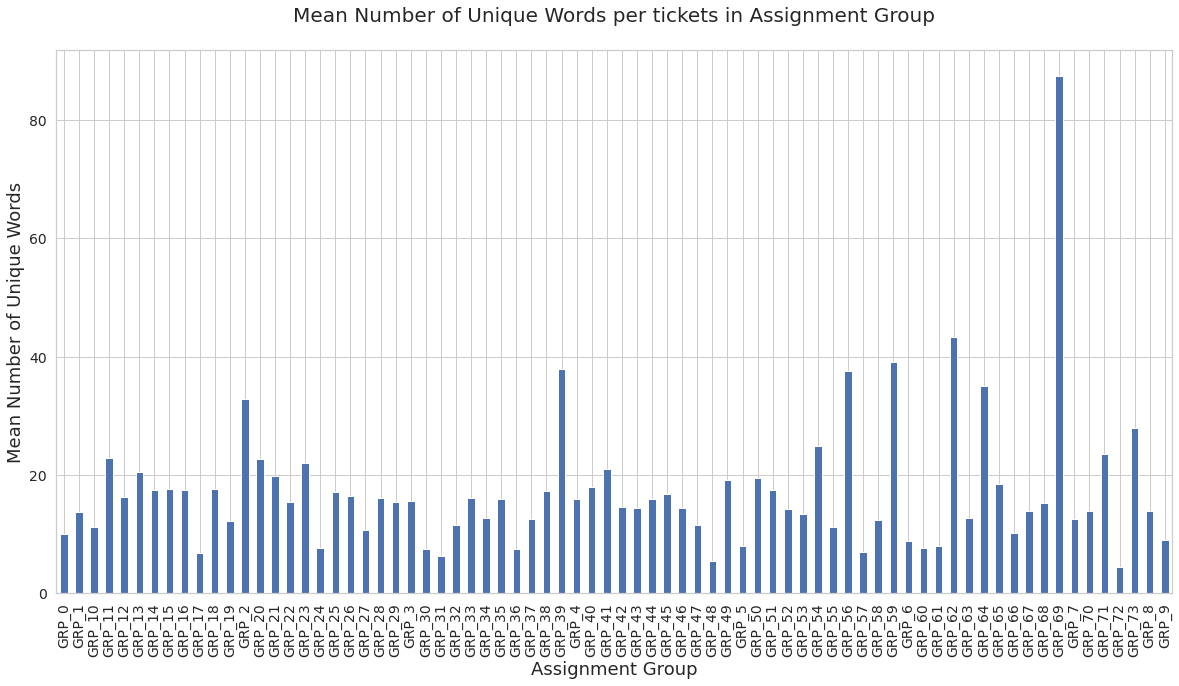

In [63]:
ax=assign_grps['uniq_wds'].aggregate(np.mean).plot(kind='bar', fontsize=14, figsize=(20,10))
ax.set_title('Mean Number of Unique Words per tickets in Assignment Group\n', fontsize=20)
ax.set_ylabel('Mean Number of Unique Words', fontsize=18)
ax.set_xlabel('Assignment Group', fontsize=18);

In [64]:
word_counts = Counter()
for i, row in augmented_data.iterrows():
    word_counts.update(row['Description_New'].split())
    
word_counts.most_common(20)

[('job', 15506),
 ('t', 13496),
 ('erp', 12068),
 ('user', 9860),
 ('password', 9013),
 ('error', 8645),
 ('failed', 8381),
 ('issue', 7632),
 ('access', 7465),
 ('e', 6967),
 ('jobscheduler', 6826),
 ('yesnona', 6512),
 ('need', 6392),
 ('company', 6306),
 ('crm', 6024),
 ('reset', 5961),
 ('email', 5933),
 ('order', 5856),
 ('sid', 5827),
 ('system', 5719)]

In [65]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
augmented_data['token_desc'] = augmented_data['Description_New'].apply(lambda x: tokenizer.tokenize(x))
augmented_data['token_desc'].head()

0    [event, criticalhostname, value, mountpoint, t...
1    [undocking, pc, screen, come, backundocking, p...
2    [duplication, network, addresskxsceyzonaokumlb...
3    [reroute, job, printer, printer, issue, need, ...
4    [job, job, failed, jobschedulermonitoringtool,...
Name: token_desc, dtype: object

In [66]:
augmented_data.head()

,Short description,Description,Caller,Assignment group,lang_desc,lang_short_desc,Description_New,num_wds,uniq_wds,token_desc
0,event criticalhostname value mountpoint thresh...,event criticalhostname value mountpoint thresh...,jyoqwxhz clhxsoqy,GRP_1,en,en,event criticalhostname value mountpoint thresh...,11,7,"[event, criticalhostname, value, mountpoint, t..."
1,undocking pc screen come back,undocking pc screen come back,sigfdwcj reofwzlm,GRP_3,en,en,undocking pc screen come backundocking pc scre...,9,6,"[undocking, pc, screen, come, backundocking, p..."
2,duplication network address,kxsceyzonaokumlb gentles two device trying sha...,kxsceyzo naokumlb,GRP_4,en,en,duplication network addresskxsceyzonaokumlb ge...,42,31,"[duplication, network, addresskxsceyzonaokumlb..."
3,reroute job printer printer issue need resolve...,yisohglruvteflgb printer printer working need ...,yisohglr uvteflgb,GRP_5,en,en,reroute job printer printer issue need resolve...,55,38,"[reroute, job, printer, printer, issue, need, ..."
4,job job failed jobscheduler,monitoringtool job job failed jobscheduler,bpctwhsn kzqsbmtp,GRP_6,en,en,job job failed jobschedulermonitoringtool job ...,8,4,"[job, job, failed, jobschedulermonitoringtool,..."


## Splitting the data into rule based and Machine learning based processing

In [67]:
rule_based_df = " "
machine_learning_df = " "
if os.path.exists(folder_path + "/rule_based_df.pickle"):
  rule_based_df = get_pickle_data("rule_based_df.pickle")
else:
  rule_based_df = augmented_data[augmented_data["Assignment group"].apply(filter_group_small)]

if os.path.exists(folder_path + "/machine_learning_df.pickle"):
  machine_learning_df = get_pickle_data("machine_learning_df.pickle")
else:
  machine_learning_df = augmented_data[augmented_data["Assignment group"].apply(filter_group_AI)]

In [68]:
machine_learning_df.shape

(65337, 10)

In [81]:
deep_learning_df.shape

(65337, 7)

In [69]:
rule_based_df.shape

(226, 10)

In [70]:
augmented_data.shape

(69765, 10)

In [71]:
machine_learning_df = machine_learning_df.reset_index()
machine_learning_df.drop(["index"], axis = 1, inplace = True)
rule_based_df = rule_based_df.reset_index()
rule_based_df.drop(["index"], axis = 1, inplace = True)
pickle_dump(rule_based_df, "rule_based_df.pickle")
pickle_dump(machine_learning_df, "machine_learning_df.pickle")

## Vocabularizing the Deep Learning Df

In [72]:
def vocabularize(text, max_features):
  x = text
  vocabSize = max_features
  tokenizer = Tokenizer(num_words=vocabSize, split=' ')
  tokenizer.fit_on_texts(x)
  x = tokenizer.texts_to_sequences(x)
  x = pad_sequences(x,MAX_LENGTH)
  return x
x = vocabularize(deep_learning_df["Description_New"], max_features)
x

array([[   0,    0,    0, ...,    8, 4187,    4],
       [   0,    0,    0, ...,    6,  632,  230],
       [   0,    0,    0, ...,   87,  381,  123],
       ...,
       [   0,    0,    0, ..., 2315,  835,    6],
       [   0,    0,    0, ...,    0,  174,   36],
       [   0,    0,    0, ...,   39,   58,    8]], dtype=int32)

In [74]:
# build the vocabulary in one pass
from string import punctuation
from nltk import word_tokenize
stop_words = []
vocabulary = set()
def tokenize(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    return [w for w in words if w not in stop_words and not w.isdigit()]

if os.path.exists(folder_path + "/vocabulary.pickle"):
  vocabulary = get_pickle_data("vocabulary.pickle")
else:
  stop_words = stopwords.words('english') + list(punctuation)
  counter = len(machine_learning_df["token_desc"])
  for  i in range(counter):
      words = tokenize(str(machine_learning_df["Description_New"][i]))
      vocabulary.update(words)

  vocabulary = list(vocabulary) 
VOCABULARY_SIZE = len(vocabulary)
  
print(VOCABULARY_SIZE)

pickle_dump(vocabulary, "vocabulary.pickle")

39586


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words=stop_words, tokenizer=tokenize, max_features=30, analyzer = 'word', ngram_range=(1, 2))
inc_tfidf = tfidf.fit_transform(machine_learning_df['Description_New'])

In [83]:
inc_tfidf.shape

(65337, 30)

In [ ]:
#  create a dictionary mapping the tokens to their tfidf values
'''tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(
                    dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

Top 20 Words with highest tfidf score

In [ ]:
'''tfidf.sort_values(by=['tfidf'], ascending=False).head(20)

Bottom 10 words with lowest tfidf score

In [ ]:
''' tfidf.sort_values(by=['tfidf'], ascending=True).head(10)

Dimentionality Reduction

In [ ]:
'''from sklearn.decomposition import TruncatedSVD

n_comp=10
svd = TruncatedSVD(n_components=n_comp, random_state=42)
svd_tfidf = svd.fit_transform(inc_tfidf)

In [ ]:
'''from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, n_iter=500)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)

In [ ]:
'''from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
# create count vectorizer first
cvectorizer = CountVectorizer(min_df=4, max_features=4000, ngram_range=(1,2))
cvz = cvectorizer.fit_transform(machine_learning_df['Description_New'])

# generate topic models using Latent Dirichlet Allocation
lda_model = LatentDirichletAllocation(n_components=10, learning_method='online', max_iter=20, random_state=42)
X_topics = lda_model.fit_transform(cvz)

In [ ]:
'''n_top_words = 10
topic_summaries = []

# get topics and topic terms
topic_word = lda_model.components_ 
vocab = cvectorizer.get_feature_names()

for i, topic_dist in enumerate(topic_word):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))
    print('Topic {}: {}'.format(i, ' | '.join(topic_words)))

In [84]:
# collect the tfid matrix in numpy array
#array = inc_tfidf.todense()
array = inc_tfidf.todense()
# store the tf-idf array into pandas dataframe
df_inc = pd.DataFrame(array)
df_inc.head(10)
df_inc.shape

(65337, 30)

In [85]:
machine_learning_df.head()

,Short description,Description,Caller,Assignment group,lang_desc,lang_short_desc,Description_New,num_wds,uniq_wds,token_desc
0,event criticalhostname value mountpoint thresh...,event criticalhostname value mountpoint thresh...,jyoqwxhz clhxsoqy,GRP_1,en,en,event criticalhostname value mountpoint thresh...,11,7,"[event, criticalhostname, value, mountpoint, t..."
1,undocking pc screen come back,undocking pc screen come back,sigfdwcj reofwzlm,GRP_3,en,en,undocking pc screen come backundocking pc scre...,9,6,"[undocking, pc, screen, come, backundocking, p..."
2,duplication network address,kxsceyzonaokumlb gentles two device trying sha...,kxsceyzo naokumlb,GRP_4,en,en,duplication network addresskxsceyzonaokumlb ge...,42,31,"[duplication, network, addresskxsceyzonaokumlb..."
3,reroute job printer printer issue need resolve...,yisohglruvteflgb printer printer working need ...,yisohglr uvteflgb,GRP_5,en,en,reroute job printer printer issue need resolve...,55,38,"[reroute, job, printer, printer, issue, need, ..."
4,job job failed jobscheduler,monitoringtool job job failed jobscheduler,bpctwhsn kzqsbmtp,GRP_6,en,en,job job failed jobschedulermonitoringtool job ...,8,4,"[job, job, failed, jobschedulermonitoringtool,..."


In [86]:
machine_learning_df.head()

,Short description,Description,Caller,Assignment group,lang_desc,lang_short_desc,Description_New,num_wds,uniq_wds,token_desc
0,event criticalhostname value mountpoint thresh...,event criticalhostname value mountpoint thresh...,jyoqwxhz clhxsoqy,GRP_1,en,en,event criticalhostname value mountpoint thresh...,11,7,"[event, criticalhostname, value, mountpoint, t..."
1,undocking pc screen come back,undocking pc screen come back,sigfdwcj reofwzlm,GRP_3,en,en,undocking pc screen come backundocking pc scre...,9,6,"[undocking, pc, screen, come, backundocking, p..."
2,duplication network address,kxsceyzonaokumlb gentles two device trying sha...,kxsceyzo naokumlb,GRP_4,en,en,duplication network addresskxsceyzonaokumlb ge...,42,31,"[duplication, network, addresskxsceyzonaokumlb..."
3,reroute job printer printer issue need resolve...,yisohglruvteflgb printer printer working need ...,yisohglr uvteflgb,GRP_5,en,en,reroute job printer printer issue need resolve...,55,38,"[reroute, job, printer, printer, issue, need, ..."
4,job job failed jobscheduler,monitoringtool job job failed jobscheduler,bpctwhsn kzqsbmtp,GRP_6,en,en,job job failed jobschedulermonitoringtool job ...,8,4,"[job, job, failed, jobschedulermonitoringtool,..."


In [87]:
df_inc = df_inc.reset_index()
df_inc.drop(['index'],axis=1, inplace = True)

In [88]:
df_inc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.469499,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.509558,0.574736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.435431,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.164548,0.449355,0.000000,0.844884,0.190591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.144395,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.471987,0.0,0.000000,0.852358,0.225197,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [89]:
df_inc['num_wds']= machine_learning_df['num_wds']
df_inc['uniq_wds']= machine_learning_df['uniq_wds']
df_inc['Assignment group']= machine_learning_df['Assignment group']
df_inc.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,num_wds,uniq_wds,Assignment group
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,11,7,GRP_1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,9,6,GRP_3
2,0.0,0.0,0.0,0.0,0.0,0.0,0.469499,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.509558,0.574736,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.435431,0.0,0.0,0.0,0.0,42,31,GRP_4
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.164548,0.449355,0.000000,0.844884,0.190591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.144395,0.0,0.0,0.0,0.0,55,38,GRP_5
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.471987,0.0,0.000000,0.852358,0.225197,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,8,4,GRP_6


In [90]:
features = df_inc.columns.tolist()
output = 'Assignment group'
# removing the output and the id from features
features.remove(output)

In [ ]:
df_inc_sample = df_inc[df_inc['Assignment group'].map(df_inc['Assignment group'].value_counts()) > 100]

In [ ]:
df_inc_sample['Assignment_group'].value_counts()

In [ ]:
def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

In [ ]:
non_eng_text=machine_learning_df.loc[machine_learning_df['Caller']=="gusyjcer lvbxfimr"]
non_eng_text